In [28]:
# 라이브러리
import torch
import numpy as np

## RNN

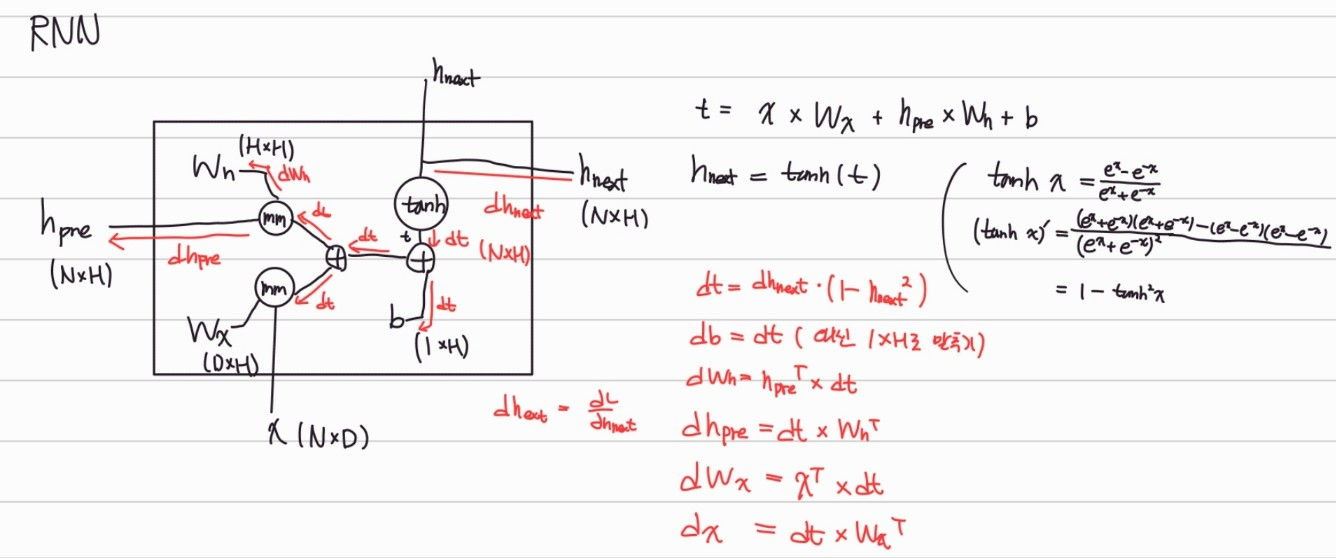

In [29]:
# RNN
class RNN:
  def __init__(self, Wx, Wh, b):
    self.params = [Wx, Wh, b]
    self.grads = [np.zeros_like(Wx), np.zeros_like(Wh),np.zeros_like(b)]
    self.cache = None

  def forward(self, x, h_pre):
    Wx, Wh, b = self.params
    t = np.dot(x,Wx) + np.dot(h_pre, Wh) + b
    h_next = np.tanh(t)

    self.cache = (x, h_pre, h_next)
    return h_next

  def backward(self, dh_next):
    Wx, Wh, b = self.params
    x, h_pre, h_next = self.cache
    # backward
    dt = dh_next*(1 - h_next**2)
    db = np.sum(dt, axis=0)
    dWh = np.dot(h_pre.T, dt)
    dh_pre = np.dot(dt, Wh.T)
    dWx = np.dot(x.T, dt)
    dx = np.dot(dt, Wx.T)
    #gradient update
    self.grad[0][...] = dWx
    self.grad[1][...] = dWh
    self.grad[2][...] = db
    return dx, dh_pre


In [30]:
batch_size = 10
embedding_size = 20
hidden_size = 16

Wx = np.random.randn(embedding_size, hidden_size)
Wh = np.random.randn(hidden_size, hidden_size)
b = np.random.randn(1, hidden_size)
rnn = RNN(Wx,Wh,b)

X = np.random.randn(batch_size, embedding_size)
h0 = np.random.randn(batch_size, hidden_size)
rnn.forward(X,h0).shape

(10, 16)

In [31]:
rnn = torch.nn.RNN(embedding_size, hidden_size, batch_first=True)

X = torch.randn(batch_size,10, embedding_size)
rnn(X)[1].size()

torch.Size([1, 10, 16])

## LSTM

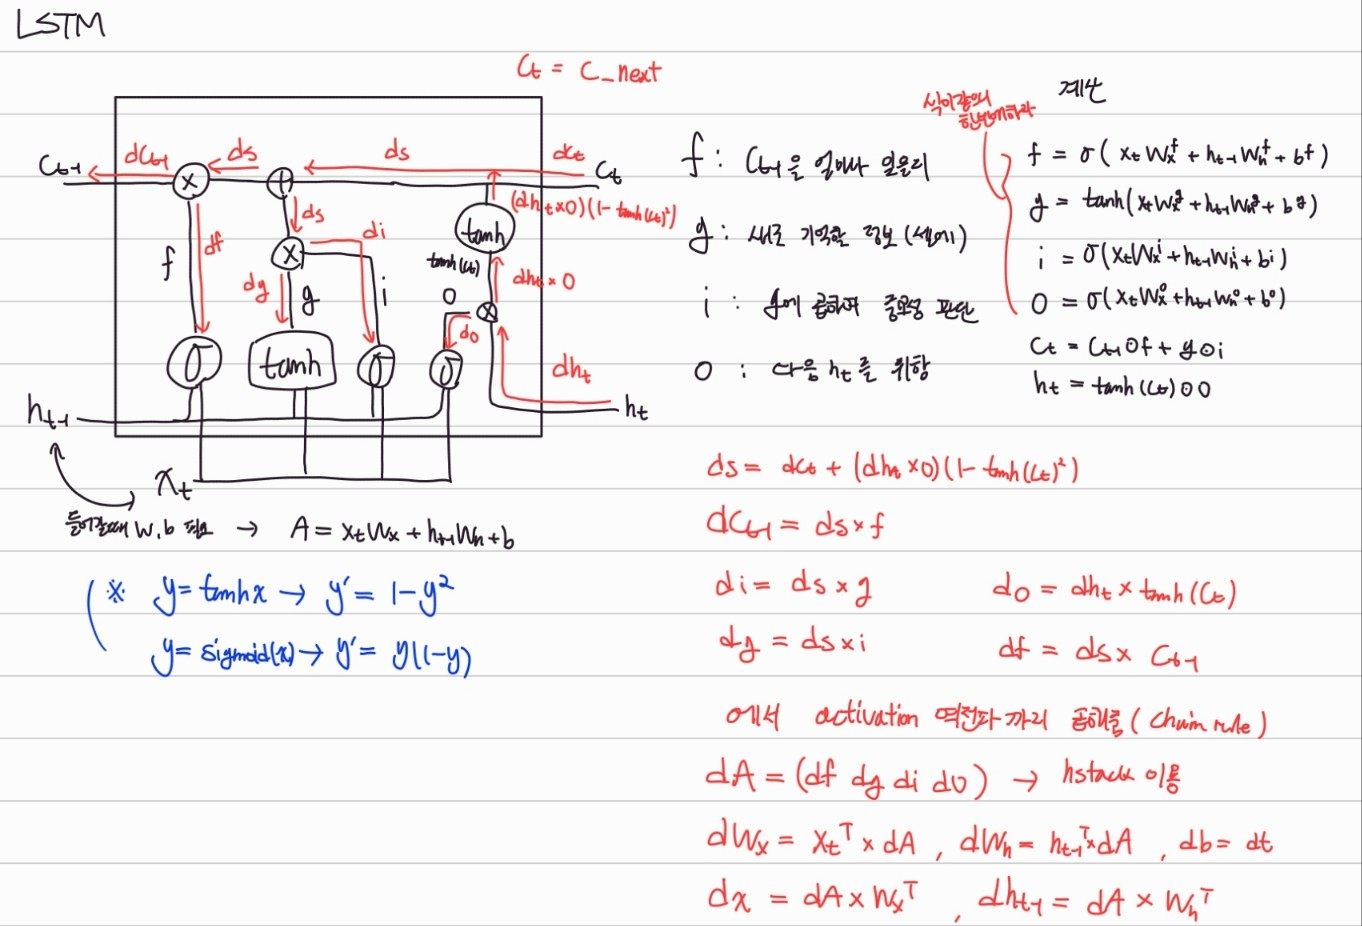

In [80]:
# LSTM

def sigmoid(x):
  return 1/1+np.exp(-x)

class LSTM:
  def __init__(self, embedding_size, hidden_size): # 원래 각각 4개씩 있는데 옆으로 이어붙임
    self.Wx = np.random.randn(embedding_size, 4*hidden_size)
    self.Wh = np.random.randn(hidden_size, 4*hidden_size)
    self.b = np.random.randn(1, 4*hidden_size)
    self.params = [self.Wx, self.Wh, self.b]
    self.grads = [np.zeros_like(self.Wx),
                  np.zeros_like(self.Wh),
                  np.zeros_like(self.b)]
    self.cache = None

  def forward(self, x, h_prev, c_prev):
    Wx, Wh, b = self.params
    N, H = h_prev.shape # H 는 hidden state의 차원이면서 cell state의 차원
    # A = f;g;i;o
    A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b # affine

    f = A[:, :H]
    g = A[:, H:2*H]
    i = A[:, 2*H:3*H]
    o = A[:, 3*H:]

    f = sigmoid(f)
    g = np.tanh(g)
    i = sigmoid(i)
    o = sigmoid(o)

    c_next = f * c_prev + g * i
    h_next = o * np.tanh(c_next)

    self.cache = (x, h_prev, c_prev, i, f, g, o, c_next) # 역전파 할 때 사용 예정
    return h_next, c_next

  def backward(self, dh_next, dc_next): # dh_next 는 들어오는 미분 3개중 같은거 2개 합친거
    Wx, Wh, b = self.params
    x, h_prev, c_prev, i, f, g, o, c_next = self.cache

    tanh_c_next = np.tanh(c_next)

    ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)

    dc_prev = ds * f

    di = ds * g
    df = ds * c_prev
    do = dh_next * tanh_c_next
    dg = ds * i

    di *= i * (1 - i)
    df *= f * (1 - f)
    do *= o * (1 - o)
    dg *= (1 - g ** 2)

    dA = np.hstack((df, dg, di, do)) # slice의 역전파는 concat

    dWh = np.dot(h_prev.T, dA)
    dWx = np.dot(x.T, dA)
    db = dA.sum(axis=0) # repeat노드의 역전파

    # 제대로 구한 역전파로 바꾸기
    self.grads[0][...] = dWx
    self.grads[1][...] = dWh
    self.grads[2][...] = db

    # 밑으로 흘려보내 밑의 층도 학습시키기
    dx = np.dot(dA, Wx.T)
    # 전 시각으로도
    dh_prev = np.dot(dA, Wh.T)

    return dx, dh_prev, dc_prev

In [85]:
batch_size = 10
embedding_size = 20
hidden_size = 16

lstm = LSTM(embedding_size,hidden_size)

X = np.random.randn(batch_size, embedding_size)
h0 = np.random.randn(batch_size, hidden_size)
C0 = np.random.randn(batch_size, hidden_size)
h,c = lstm.forward(X,h0,C0)

## GRU

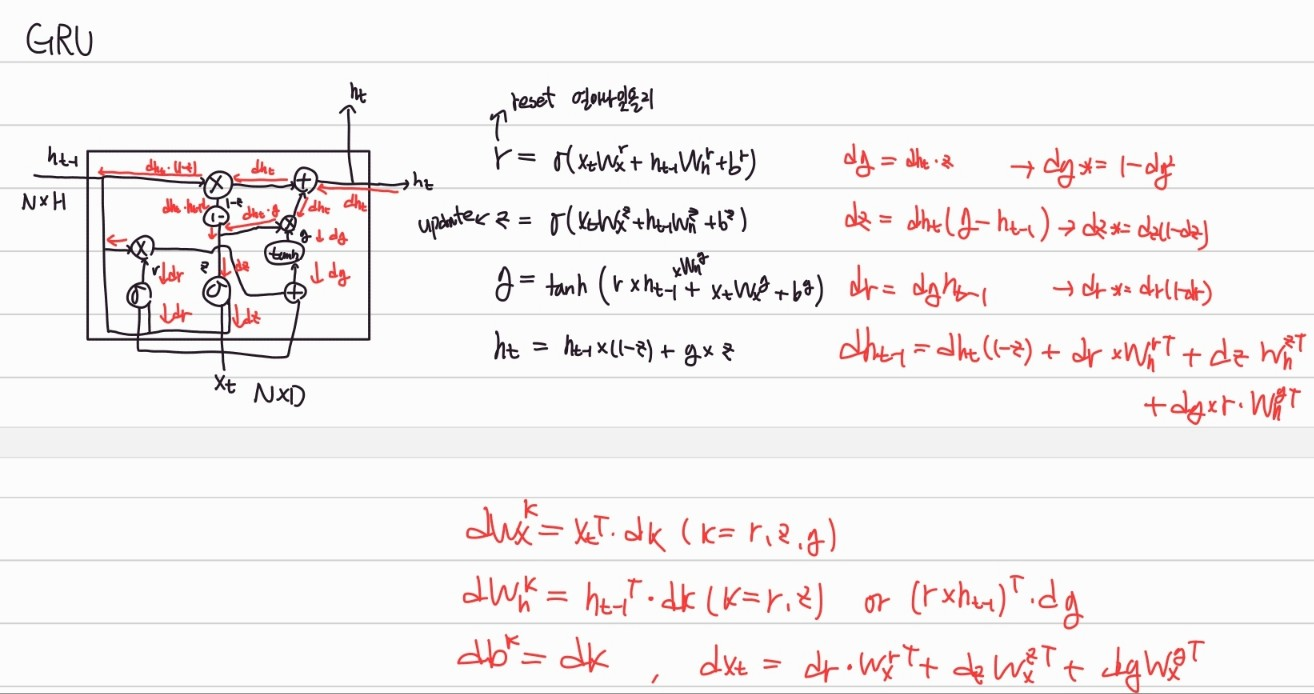

In [51]:
# GRU
def sigmoid(x):
  return 1/1+np.exp(-x)

class GRU:
  def __init__(self, embedding_size, hidden_size): # 원래 각각 4개씩 있는데 옆으로 이어붙임
    self.Wx = np.random.randn(embedding_size, 3*hidden_size)
    self.Wh = np.random.randn(hidden_size, 3*hidden_size)
    self.b = np.random.randn(1, 3*hidden_size)
    self.params = [self.Wx, self.Wh, self.b]
    self.grads = [np.zeros_like(self.Wx),
                  np.zeros_like(self.Wh),
                  np.zeros_like(self.b)]
    self.cache = None

  def forward(self, x, h_prev):
    Wx, Wh, b = self.params
    N, H = h_prev.shape

    Wxr = Wx[:,:H]
    Wxz = Wx[:,H:2*H]
    Wxg = Wx[:,2*H:]
    Whr = Wh[:,:H]
    Whz = Wh[:,H:2*H]
    Whg = Wh[:,2*H:]
    br = b[:,:H]
    bz = b[:,H:2*H]
    bg = b[:,2*H:]
    
    r = sigmoid(np.dot(x,Wxr) + np.dot(h_prev,Whr) + br)
    z = sigmoid(np.dot(x,Wxz) + np.dot(h_prev,Whz) + bz)
    g = np.tanh(np.dot(x,Wxg) + np.dot(r*h_prev,Whg) + bg)
    h_next = h_prev*(1-z) + g*z

    self.cache = (x, h_prev, r,z,g) # 역전파 할 때 사용 예정
    return h_next

  def backward(self, dh_next): # dh_next 는 들어오는 미분 3개중 같은거 2개 합친거
    Wx, Wh, b = self.params
    x, h_prev, r,z,g = self.cache
    N, H = h_prev.shape

    Wxr = Wx[:,:H]
    Wxz = Wx[:,H:2*H]
    Wxg = Wx[:,2*H:]
    Whr = Wh[:,:H]
    Whz = Wh[:,H:2*H]
    Whg = Wh[:,2*H:]
    br = b[:,:H]
    bz = b[:,H:2*H]
    bg = b[:,2*H:]

    dg = dh_next*z
    dg*=(1-dg**2)
    dz = dh_next*(g-h_prev)
    dz *= dz*(1-dz)
    dr = dg*h_prev
    dr *= dr*(1-dr)
    dh_prev = dh_next*(1-z) + np.dot(dr,Whr.T) + np.dot(dz,Whz.T) + np.dot(dg*r,Whg.T)
    dx = np.dot(dr,Wxr.T) + np.dot(dz,Wxz.T) + np.dot(dg,Wxg.T)

    dWxr = np.dot(x.T, dr)
    dWxz = np.dot(x.T, dz)
    dWxg = np.dot(x.T, dg)
    dWhr = np.dot(h_prev.T, dr)
    dWhz = np.dot(h_prev.T, dz)
    dWhg = np.dot((r*h_prev).T, dg)
    dbr = np.sum(dr, axis=0)
    dbz = np.sum(dz, axis=0)
    dbg = np.sum(dg, axis=0)

    # 제대로 구한 역전파로 바꾸기
    self.grads[0][...] = np.hstack((dWxr,dWxz,dWxg))
    self.grads[1][...] = np.hstack((dWhr,dWhz,dWhg))
    self.grads[2][...] = np.hstack((dbr,dbz,dbg))

    return dx, dh_prev

In [52]:
batch_size = 10
embedding_size = 20
hidden_size = 16

gru = GRU(embedding_size,hidden_size)

X = np.random.randn(batch_size, embedding_size)
h0 = np.random.randn(batch_size, hidden_size)
hs = gru.forward(X,h0)
hs.shape

(10, 16)

In [56]:
dx, dh_prev = gru.backward(hs)
dh_prev.shape

(10, 16)

In [62]:
gru = torch.nn.GRU(embedding_size, hidden_size,batch_first=True)
X = torch.randn(batch_size, 12, embedding_size)
out,h = gru(X)
out.size()

torch.Size([10, 12, 16])